In [40]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [41]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0],bias=False)
        for k in range(len(hidden_sizes)-1):
            self.hidden.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1],bias=False))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size,bias=False)
        
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x

def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [42]:
INPUT_SIZE=784
HIDDEN_SIZES=[500,300,100]
OUTPUT_SIZE=10
BATCH_SIZE=100
LEARNING_RATE=0.01
NUM_EPOCHS=200

M_TRAIN=10000
M_VAL=2000

In [43]:
# Import the MNIST dataset as two separate datasets

train_dataset = torchvision.datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)

validation_dataset = torchvision.datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())

reduced_train_index=list(range(M_TRAIN))
reduced_test_index=list(range(M_VAL))

subset_train_dataset=Subset(train_dataset, reduced_train_index)
subset_validation_dataset=Subset(validation_dataset, reduced_test_index)

# Create the data loader for training
train_dataset_loader = DataLoader(subset_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create the data loader for validating

validation_dataset_loader = DataLoader(subset_validation_dataset, batch_size=BATCH_SIZE, shuffle=False) 

In [44]:
def strat_sample(train_dataset):

    train_stratified_sample=[0,0,0,0,0,0,0,0,0,0]
    unidentified_label=[0,1,2,3,4,5,6,7,8,9]

    counter=np.random.randint(0,1000)
    while len(unidentified_label)>0:
        label=train_dataset[counter][1]
        if label in unidentified_label:
            unidentified_label.remove(label)
            train_stratified_sample[label]=counter
        counter+=1
    return train_stratified_sample

strat_loader_1 = DataLoader(dataset=Subset(train_dataset,strat_sample(train_dataset)))
strat_loader_2 = DataLoader(dataset=Subset(train_dataset,strat_sample(train_dataset)))

In [45]:
def stiffness(x_1,x_2):
    return np.dot(x_1/norm(x_1),x_2/norm(x_2))

In [46]:
model=NeuralNet(INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE)
ReLU_glorot_init(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

def train_epoch(stiff_matrix=False):
    if stiff_matrix:
        class_gradients_1=[]
        for image, label in strat_loader_1:
            image = image.reshape(-1,28*28)
            output=model(image)
            optimizer.zero_grad()
            loss1=criterion(output,label)
            loss1.backward()

            gradient=[]
            gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
            for layer in model.hidden:
                gradient+=torch.flatten(layer.weight.grad).tolist()
            gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
            class_gradients_1.append(np.array(gradient))

        class_gradients_2=[]
        for image, label in strat_loader_2:
            image = image.reshape(-1,28*28)
            output=model(image)
            optimizer.zero_grad()
            loss1=criterion(output,label)
            loss1.backward()

            gradient=[]
            gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
            for layer in model.hidden:
                gradient+=torch.flatten(layer.weight.grad).tolist()
            gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
            class_gradients_2.append(np.array(gradient))
        
        stiffness_matrix=np.zeros((OUTPUT_SIZE,OUTPUT_SIZE))
        for n, x_1 in enumerate(class_gradients_1):
            for m, x_2 in enumerate(class_gradients_2):
                stiffness_matrix[n][m]=stiffness(x_1,x_2)

        for images, labels in train_dataset_loader:  
            images = images.reshape(-1, 28*28)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return loss.item(), stiffness_matrix
    else:
        for images, labels in train_dataset_loader:  
            images = images.reshape(-1, 28*28)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return loss.item()

stiff_matrices_epochs=[0,1,4,9,19,49,74,99,149,199]

stiff_matrices=[]
for n in range(NUM_EPOCHS):
    if n in stiff_matrices_epochs:
        loss, stiff_matrix=train_epoch(stiff_matrix=True)
        stiff_matrices.append(stiff_matrix)
    else:
        loss=train_epoch()
    print('Epoch {}: Loss {:.3f}'.format(n+1,loss))

Epoch 1: Loss 1.789
Epoch 2: Loss 1.145
Epoch 3: Loss 0.818
Epoch 4: Loss 0.668
Epoch 5: Loss 0.446
Epoch 6: Loss 0.354
Epoch 7: Loss 0.396
Epoch 8: Loss 0.475
Epoch 9: Loss 0.489
Epoch 10: Loss 0.320
Epoch 11: Loss 0.344
Epoch 12: Loss 0.322
Epoch 13: Loss 0.218
Epoch 14: Loss 0.244
Epoch 15: Loss 0.217
Epoch 16: Loss 0.416
Epoch 17: Loss 0.281
Epoch 18: Loss 0.266
Epoch 19: Loss 0.173
Epoch 20: Loss 0.113
Epoch 21: Loss 0.180
Epoch 22: Loss 0.178
Epoch 23: Loss 0.268
Epoch 24: Loss 0.251
Epoch 25: Loss 0.137
Epoch 26: Loss 0.139
Epoch 27: Loss 0.213
Epoch 28: Loss 0.149
Epoch 29: Loss 0.134
Epoch 30: Loss 0.343
Epoch 31: Loss 0.138
Epoch 32: Loss 0.198
Epoch 33: Loss 0.077
Epoch 34: Loss 0.081
Epoch 35: Loss 0.070
Epoch 36: Loss 0.166
Epoch 37: Loss 0.155
Epoch 38: Loss 0.162
Epoch 39: Loss 0.131
Epoch 40: Loss 0.130
Epoch 41: Loss 0.140
Epoch 42: Loss 0.144
Epoch 43: Loss 0.194
Epoch 44: Loss 0.091
Epoch 45: Loss 0.092
Epoch 46: Loss 0.089
Epoch 47: Loss 0.096
Epoch 48: Loss 0.092
E

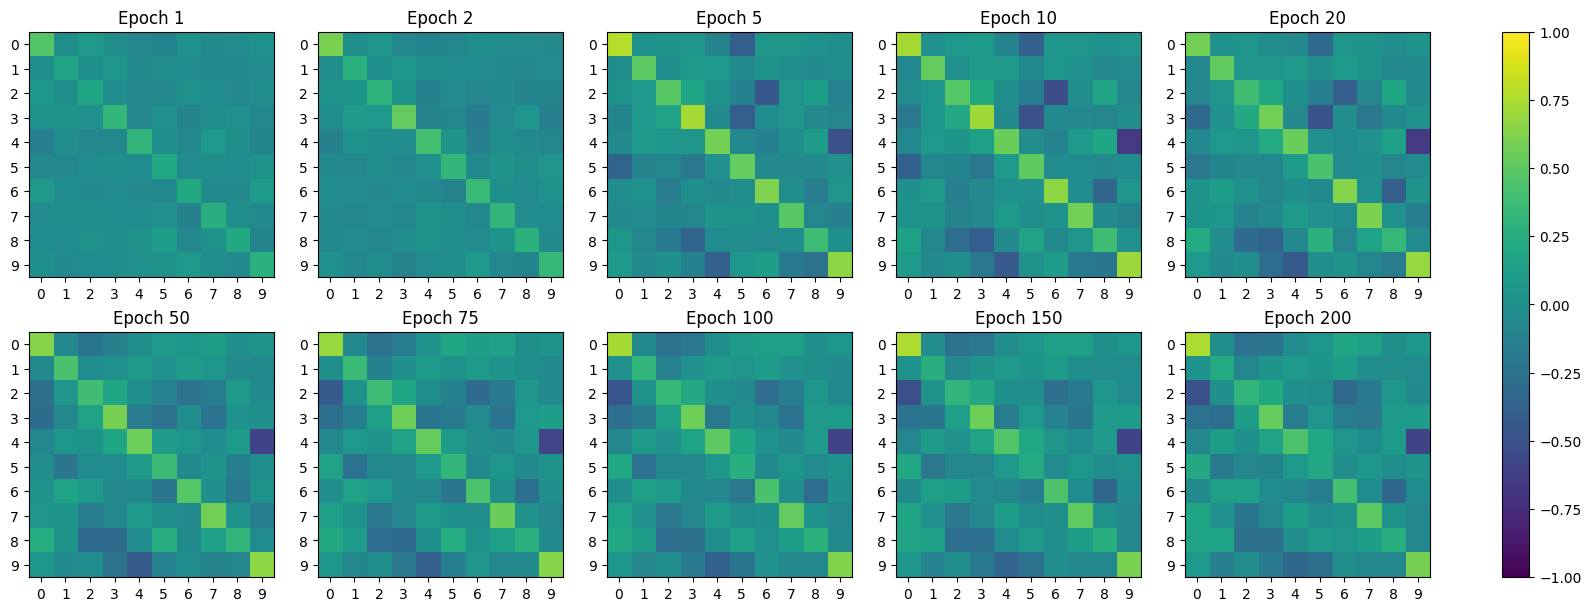

In [57]:
fig, axs = plt.subplots(ncols=5,nrows=2, figsize=(16,6), layout='constrained')

for col in range(5):
    for row in range(2):
        pcm=axs[row,col].imshow(stiff_matrices[row*5+col],vmin=-1,vmax=1)
        axs[row,col].set_title('Epoch {}'.format(stiff_matrices_epochs[row*5+col]+1))
        axs[row,col].set_xticks([0,1,2,3,4,5,6,7,8,9])
        axs[row,col].set_yticks([0,1,2,3,4,5,6,7,8,9])

fig.colorbar(pcm, ax=axs)

fig.savefig('plots/Stiffness_Over_Training.png')

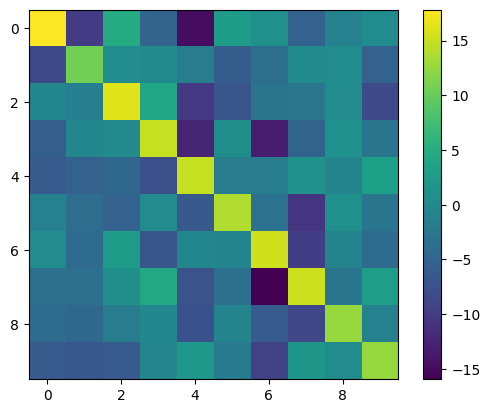

In [64]:
def strat_sample(train_dataset, samples_per_cat):

    train_stratified_sample=[[],[],[],[],[],[],[],[],[],[]]
    unidentified_label=[0,1,2,3,4,5,6,7,8,9]
    cat_counts=[0,0,0,0,0,0,0,0,0,0]

    counter=0
    while len(unidentified_label)>0:
        label=train_dataset[counter][1]
        if label in unidentified_label:
            train_stratified_sample[label].append(counter)
            cat_counts[label]+=1
            if cat_counts[label]==samples_per_cat:
                unidentified_label.remove(label)
        counter+=1
    return train_stratified_sample

average_outputs=[]


for list_indicies in strat_sample(train_dataset,500):
    loader=DataLoader(dataset=Subset(train_dataset,list_indicies),batch_size=len(list_indicies))
    for images,labels in loader:
        images=images.reshape(-1,28*28)
        output=model(images)
    average_ten=torch.zeros(10)
    for ten in output:
        average_ten+=ten/500
    average_outputs.append(average_ten.detach().numpy())

fig, (ax1) = plt.subplots(1,1)
p1 = ax1.imshow(average_outputs)
fig.colorbar(p1,ax=ax1)
fig.savefig('plots/Last_Layer_Activity.png')